In [1]:
import pandas as pd
import numpy as np 
import re
import string
import tqdm
import matplotlib.pyplot as plt

In [2]:
res = []
with open('../data/gdn_common_sorted.txt') as file : 
    for j, line in enumerate(file): 
        if j > 0 : 
            res.append(line.split(' ')[:701])
res = np.asarray(res)
embedding = pd.DataFrame(res[:,1:], index=res[:,0])
embeded_words = {}

for word in embedding.index : 
    embeded_words[word.split('_')[0]] = word
    

In [3]:
data = pd.read_csv('../data/data_F.csv', sep=';') # lecture data set 
department = np.copy(data['zip_code'].values)

In [4]:
def preprocess(sentence): 
    '''
    return the sentence passed in argmuents with no punctuation
    '''
    sentence = sentence.replace('\'',' ').lower()
    table = sentence.maketrans('', '', string.punctuation)
    sentence = [w.translate(table) for w in sentence]
    sentence = ''.join(sentence)

    return sentence

def embed_answer(sentence): 
    sentence_embedding = []
    sentence = preprocess(sentence)
    for i, word in enumerate(sentence.split(' ')):
        try : 
            if not embeded_words[word].endswith('_i'):
                sentence_embedding.append(embedding.loc[embeded_words[word]].tolist())
        except KeyError: 
            continue
    
    return(np.asarray(sentence_embedding, dtype=np.float64))
   
def compute_variance(sentence_embedding, eval_type='var'):
    result = 0
    if eval_type == 'var':
        for index in range(len(sentence_embedding[0])):
            result += np.var(sentence_embedding[:,index])
            
    elif eval_type == 'dist':
        n = len(sentence_embedding)
        for word_1_idx in range(n-1):
            for word_2_idx in range(word_1_idx+1,n):
                result += np.linalg.norm(sentence_embedding[word_1_idx]-sentence_embedding[word_2_idx])
        result = result*2/(n*(n-1))

    return result

def compute_moyenne(sentence_embedding):
    result = []
    #print(len(sentence_embedding[0]))
    for index in range(len(sentence_embedding[0])): # taille 700
        result.append(np.sum(sentence_embedding[:,index])/len(sentence_embedding))
    return result

In [5]:
scores = []
for index in tqdm.tqdm(range(len(data))):
    answer = embed_answer(data.iloc[index]['solution'])
    if len(answer)>1:
        # score de taille 700
        scores.append(compute_moyenne(answer))#,compute_variance(answer, eval_type='var'),compute_variance(answer, eval_type='dist')])
    else:
        scores.append([np.nan]*700)
        
# Total = 15309
scores_df = pd.DataFrame(data=np.array(scores),index=data.index, columns = ['score_'+str(i) for i in range(700)]) 
argumentation_scores = pd.concat([data['annotation'],scores_df], axis=1) 
argumentation_scores.head(2)

100%|██████████| 2445/2445 [00:37<00:00, 65.32it/s]


,annotation,score_0,score_1,score_2,score_3,score_4,score_5,score_6,score_7,score_8,...,score_690,score_691,score_692,score_693,score_694,score_695,score_696,score_697,score_698,score_699
0,1.0,0.002184,-0.015336,-0.015614,0.004679,0.032181,0.061739,-0.052617,0.034983,-0.054036,...,0.029986,0.039820,-0.003342,0.030171,-0.050199,0.039690,-0.009338,-0.014119,0.052214,-0.037971
1,1.0,0.063287,-0.016981,0.022253,-0.004149,0.041670,0.072220,-0.055472,0.000335,-0.045204,...,0.010781,0.019873,-0.005545,-0.014305,-0.030772,0.017193,0.039085,0.000324,0.008392,-0.034817


In [6]:
argumentation_scores = argumentation_scores.dropna()
print(argumentation_scores.shape)
X = argumentation_scores.drop('annotation',axis=1)
Y = argumentation_scores['annotation']
X.head(2)
Y.head(2)

(2445, 701)


0    1.0
1    1.0
Name: annotation, dtype: float64

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
freq_1 = y_train.mean()

### Unbalanced weights

In [9]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C=9)
svclassifier.fit(X_train, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[1223  206]
 [ 112  415]]
             precision    recall  f1-score   support

        0.0       0.92      0.86      0.88      1429
        1.0       0.67      0.79      0.72       527

avg / total       0.85      0.84      0.84      1956

1956 621.0
0.7229965156794425
---------------Scores on test---------------
[[288  64]
 [ 85  52]]
             precision    recall  f1-score   support

        0.0       0.77      0.82      0.79       352
        1.0       0.45      0.38      0.41       137

avg / total       0.68      0.70      0.69       489

489 137.0
0.4110671936758893


### Default Balanced weights

In [10]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C=5, class_weight='balanced')
svclassifier.fit(X_train, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[1003   74]
 [ 332  547]]
             precision    recall  f1-score   support

        0.0       0.75      0.93      0.83      1077
        1.0       0.88      0.62      0.73       879

avg / total       0.81      0.79      0.79      1956

1956 621.0
0.7293333333333333
---------------Scores on test---------------
[[222 130]
 [ 41  96]]
             precision    recall  f1-score   support

        0.0       0.84      0.63      0.72       352
        1.0       0.42      0.70      0.53       137

avg / total       0.73      0.65      0.67       489

489 137.0
0.5289256198347108


### Custom Balanced weights

In [11]:
from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C=9, class_weight= {0:freq_1, 1:1-freq_1})
svclassifier.fit(X_train, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[989  80]
 [346 541]]
             precision    recall  f1-score   support

        0.0       0.74      0.93      0.82      1069
        1.0       0.87      0.61      0.72       887

avg / total       0.80      0.78      0.78      1956

1956 621.0
0.7175066312997348
---------------Scores on test---------------
[[218 134]
 [ 43  94]]
             precision    recall  f1-score   support

        0.0       0.84      0.62      0.71       352
        1.0       0.41      0.69      0.52       137

avg / total       0.72      0.64      0.66       489

489 137.0
0.5150684931506849


### Dimensionality reduction 

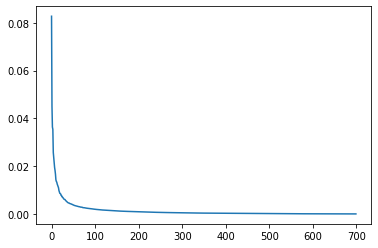

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=700)
pca.fit_transform(X_train)
plt.plot(pca.explained_variance_ratio_)


In [13]:
pca = PCA(n_components=40)
pca.fit_transform(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test) 

In [14]:
## from sklearn.svm import SVC
svclassifier = SVC(kernel='linear', C=11e1, class_weight= 'balanced')
svclassifier.fit(X_train_pca, y_train)

print(15*'-' +'Scores on train' + 15*'-' )
y_pred = svclassifier.predict(X_train_pca)
print(confusion_matrix(y_pred,y_train))
print(classification_report(y_pred, y_train))
print(len(y_train), np.sum(y_train))
print(f1_score(y_pred,y_train))

print(15*'-' +'Scores on test' + 15*'-' )
y_pred = svclassifier.predict(X_test_pca)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(len(y_test), np.sum(y_test))
print(f1_score(y_pred,y_test))

---------------Scores on train---------------
[[820 133]
 [515 488]]
             precision    recall  f1-score   support

        0.0       0.61      0.86      0.72       953
        1.0       0.79      0.49      0.60      1003

avg / total       0.70      0.67      0.66      1956

1956 621.0
0.6009852216748769
---------------Scores on test---------------
[[213 139]
 [ 29 108]]
             precision    recall  f1-score   support

        0.0       0.88      0.61      0.72       352
        1.0       0.44      0.79      0.56       137

avg / total       0.76      0.66      0.67       489

489 137.0
0.5625000000000001


### Cross Validation 

In [15]:
from tqdm import trange
n_split = 10
n_val = 800
cv_parameters = {'log_10_C': [-1, 2],
                 'n_comp':[10, 400] }
scores = []
log_10_cs = []
n_comps = []

progress_bar = trange(n_val, desc='Bar desc', leave=True)
for n in progress_bar:
    log_10_c = np.random.random() * (cv_parameters['log_10_C'][1] - cv_parameters['log_10_C'][0]) + cv_parameters['log_10_C'][0]
    n_comp = int(np.random.random() * (cv_parameters['n_comp'][1] - cv_parameters['n_comp'][0]) + cv_parameters['n_comp'][0])
    n_comps.append(n_comp)
    log_10_cs.append(log_10_c)
    f1_mean = []
    for split in range(n_split): 
        
        X_cv_train, X_val, y_cv_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=split)
        
        pca = PCA(n_components=n_comp)
        
        pca.fit_transform(X_train)
        X_train_pca = pca.transform(X_cv_train)
        X_test_pca = pca.transform(X_val)
        
        svclassifier = SVC(kernel='linear', C=10**log_10_c, class_weight= 'balanced')
        svclassifier.fit(X_train_pca, y_cv_train)
        
        y_pred = svclassifier.predict(X_test_pca)
        f1_mean.append(f1_score(y_pred,y_val))
    scores.append(np.mean(f1_mean))
    i_max = scores.index(max(scores))
    progress_bar.set_description('best f1 : {:.2e} |  for C = {:.2e} with {} components'.format(scores[i_max], 10**log_10_cs[i_max], n_comps[i_max]))
    progress_bar.refresh()
    
        
i_max = scores.index(max(scores))
print('best f1 : {:.2e} |  for C = {:.2e} with {} components'.format(scores[i_max], 10**log_10_cs[i_max], n_comps[i_max]))


best f1 : 6.03e-01 |  for C = 1.20e+00 with 313 components:   8%|▊         | 66/800 [15:33<2:56:55, 14.46s/it]

KeyboardInterrupt: 

### Switching from mean to Principal Component

In [ ]:
def get_principal_components(sentence, k=5):
    pca = PCA(n_components=k)
    pcs = pca.fit_transform(X_train)
    return pcs.flatten()


In [ ]:
scores = []
k = 5
for index in tqdm.tqdm(range(len(data))):
    answer = embed_answer(data.iloc[index]['solution'])
    if len(answer)>k:
        scores.append(get_principal_components(answer))#,compute_variance(answer, eval_type='var'),compute_variance(answer, eval_type='dist')])
    else:
        scores.append([np.nan]*700*k)
        
# Total = 15309
scores_df = pd.DataFrame(data=np.array(scores),index=data.index, columns = ['score_'+str(i) for i in range(700)]) 
argumentation_scores = pd.concat([data['annotation'],scores_df], axis=1) 
argumentation_scores.head(2)